In [255]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from tensorflow.keras import Sequential, layers, losses, optimizers, models
import tensorflow as tf
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [256]:
seed_num = 128
import random as python_random
np.random.seed(seed_num)
python_random.seed(seed_num)
tf.random.set_seed(seed_num)

In [257]:
np.set_printoptions(threshold=np.inf) #무한으로 출력합니다. (sys.maxsize 크기 만큼 출력)

In [258]:
#excel_data=pd.read_excel('돼지치수_70마리_1022개.xlsx', sheet_name='체형데이터_1022', header=1)
excel_data=pd.read_csv('Total/ResultWeight_MainDimension.csv',header=None)

In [259]:
num_data = excel_data.to_numpy()
inx = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,24,25,26,27,28,29,30,31,32,33,34,35,36]
data1 = num_data[:,inx]
폭 = np.average(num_data[:,37:41],axis=1)
높이 = np.average(num_data[:,41:45],axis=1)
면적 = np.average(num_data[:,49:53],axis=1)
둘레 = np.average(num_data[:,53:57],axis=1)

면적둘레 = 면적/둘레
면적폭 = 면적/폭
면적높이 = 면적/높이
폭=np.reshape(폭,(num_data.shape[0],1))
높이=np.reshape(높이,(num_data.shape[0],1))
면적=np.reshape(면적,(num_data.shape[0],1))
둘레=np.reshape(둘레,(num_data.shape[0],1))
면적둘레=np.reshape(면적둘레,(num_data.shape[0],1))
면적폭=np.reshape(면적폭,(num_data.shape[0],1))
면적높이=np.reshape(면적높이,(num_data.shape[0],1))
data2 = np.concatenate((data1,폭,높이,면적,둘레,면적둘레,면적폭,면적높이,num_data[:,57:59]),axis=1)
num_data2 = data2
돼지파일명 = num_data[0:,0]
치수 = num_data2[0:,0:-2]
체형 = num_data2[0:,-1].astype('float32')
print(f'치수_shape = {치수.shape}\n체형_shape = {체형.shape}') #35개의 선별 치수 + 둘레, 폭, 높이당 면적

치수_shape = (798, 38)
체형_shape = (798,)


In [260]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(치수)

치수_train, 체형_train, 치수_test, 체형_test = 치수[:round(치수.shape[0]*0.7)], 체형[:round(치수.shape[0]*0.7)], 치수[round(치수.shape[0]*0.7):], 체형[round(치수.shape[0]*0.7):]
체형_train= 체형_train-1
체형_test = 체형_test-1
# ---scaler 저장---
from pickle import dump
dump(minmax_scaler, open('./minmax_scaler.pkl', 'wb'))

'''
#---scaler 불러오기---
from pickle import load
load_minmax_scaler = load(open('./minmax_scaler.pkl', 'rb'))
'''

"\n#---scaler 불러오기---\nfrom pickle import load\nload_minmax_scaler = load(open('./minmax_scaler.pkl', 'rb'))\n"

In [261]:
체형_train

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [262]:
치수_scaled = minmax_scaler.transform(치수_train)

In [263]:
shuff = np.arange(치수_scaled.shape[0])
np.random.shuffle(shuff)
shuff_train, shuff_val = shuff[:round(shuff.shape[0]*0.7)], shuff[round(shuff.shape[0]*0.7):]

## 분류모델 생성

In [264]:
checkpoint_path = './temp/checkpoint.ckpt'
optimizer = optimizers.Adam()
model = Sequential()
model_check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)
model.add(tf.keras.layers.Dense(38, input_dim =38,activation = 'relu'))
model.add(tf.keras.layers.Dense(19,activation = 'relu'))
model.add(tf.keras.layers.Dense(19,activation = 'relu'))
model.add(tf.keras.layers.Dense(9,activation = 'relu'))
model.add(tf.keras.layers.Dense(3,  activation='softmax'))
model.compile(
    loss=sparse_categorical_crossentropy, 
    optimizer=optimizer, 
    metrics=['acc'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 38)                1482      
                                                                 
 dense_81 (Dense)            (None, 19)                741       
                                                                 
 dense_82 (Dense)            (None, 19)                380       
                                                                 
 dense_83 (Dense)            (None, 9)                 180       
                                                                 
 dense_84 (Dense)            (None, 3)                 30        
                                                                 
Total params: 2,813
Trainable params: 2,813
Non-trainable params: 0
_________________________________________________________________


## 학습 진행

In [265]:
history = model.fit(치수_scaled[shuff_train], 체형_train[shuff_train], validation_data=(치수_scaled[shuff_val], 체형_train[shuff_val]), batch_size=32, epochs=500, callbacks = model_check_point)

Epoch 1/500
13/13 [==============================] - 1s 22ms/step - loss: 1.0875 - acc: 0.3478 - val_loss: 1.0677 - val_acc: 0.6131
Epoch 2/500
13/13 [==============================] - 0s 7ms/step - loss: 1.0480 - acc: 0.6292 - val_loss: 1.0288 - val_acc: 0.6071
Epoch 3/500
13/13 [==============================] - 0s 7ms/step - loss: 1.0066 - acc: 0.6292 - val_loss: 0.9837 - val_acc: 0.6071
Epoch 4/500
13/13 [==============================] - 0s 7ms/step - loss: 0.9537 - acc: 0.6292 - val_loss: 0.9311 - val_acc: 0.6071
Epoch 5/500
13/13 [==============================] - 0s 6ms/step - loss: 0.9034 - acc: 0.6292 - val_loss: 0.9069 - val_acc: 0.6071
Epoch 6/500
13/13 [==============================] - 0s 4ms/step - loss: 0.8878 - acc: 0.6292 - val_loss: 0.9077 - val_acc: 0.6071
Epoch 7/500
13/13 [==============================] - 0s 7ms/step - loss: 0.8764 - acc: 0.6292 - val_loss: 0.8985 - val_acc: 0.6071
Epoch 8/500
13/13 [==============================] - 0s 6ms/step - loss: 0.8665 - 

13/13 [==============================] - 0s 3ms/step - loss: 0.3588 - acc: 0.8721 - val_loss: 0.4013 - val_acc: 0.8571
Epoch 64/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3715 - acc: 0.8465 - val_loss: 0.4030 - val_acc: 0.8571
Epoch 65/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3603 - acc: 0.8568 - val_loss: 0.4334 - val_acc: 0.8452
Epoch 66/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3567 - acc: 0.8670 - val_loss: 0.4001 - val_acc: 0.8571
Epoch 67/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3563 - acc: 0.8542 - val_loss: 0.4175 - val_acc: 0.8571
Epoch 68/500
13/13 [==============================] - 0s 4ms/step - loss: 0.3607 - acc: 0.8670 - val_loss: 0.4509 - val_acc: 0.8274
Epoch 69/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3593 - acc: 0.8619 - val_loss: 0.4037 - val_acc: 0.8690
Epoch 70/500
13/13 [==============================] - 0s 6ms/step - loss: 0.3486 - acc: 0

Epoch 125/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3034 - acc: 0.8926 - val_loss: 0.4083 - val_acc: 0.8333
Epoch 126/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2980 - acc: 0.8772 - val_loss: 0.3746 - val_acc: 0.8452
Epoch 127/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3142 - acc: 0.8696 - val_loss: 0.4181 - val_acc: 0.8095
Epoch 128/500
13/13 [==============================] - 0s 8ms/step - loss: 0.3047 - acc: 0.8696 - val_loss: 0.3533 - val_acc: 0.8631
Epoch 129/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3091 - acc: 0.8645 - val_loss: 0.3598 - val_acc: 0.8571
Epoch 130/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3044 - acc: 0.8721 - val_loss: 0.3552 - val_acc: 0.8750
Epoch 131/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2862 - acc: 0.8951 - val_loss: 0.3667 - val_acc: 0.8690
Epoch 132/500
13/13 [==============================] - 0s 3ms/step - 

13/13 [==============================] - 0s 3ms/step - loss: 0.2367 - acc: 0.8977 - val_loss: 0.3427 - val_acc: 0.8690
Epoch 187/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2437 - acc: 0.9182 - val_loss: 0.3432 - val_acc: 0.8571
Epoch 188/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2440 - acc: 0.9054 - val_loss: 0.3493 - val_acc: 0.8512
Epoch 189/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2709 - acc: 0.8798 - val_loss: 0.3350 - val_acc: 0.8750
Epoch 190/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2523 - acc: 0.9003 - val_loss: 0.3686 - val_acc: 0.8512
Epoch 191/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2643 - acc: 0.8951 - val_loss: 0.3405 - val_acc: 0.8750
Epoch 192/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2547 - acc: 0.8926 - val_loss: 0.4127 - val_acc: 0.8274
Epoch 193/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2330 -

Epoch 248/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2229 - acc: 0.9233 - val_loss: 0.3702 - val_acc: 0.8512
Epoch 249/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2208 - acc: 0.9207 - val_loss: 0.3814 - val_acc: 0.8512
Epoch 250/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2278 - acc: 0.9130 - val_loss: 0.3117 - val_acc: 0.8810
Epoch 251/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2079 - acc: 0.9258 - val_loss: 0.2989 - val_acc: 0.8869
Epoch 252/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2121 - acc: 0.9079 - val_loss: 0.3040 - val_acc: 0.8929
Epoch 253/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2173 - acc: 0.9156 - val_loss: 0.3313 - val_acc: 0.8631
Epoch 254/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2040 - acc: 0.9309 - val_loss: 0.3273 - val_acc: 0.8750
Epoch 255/500
13/13 [==============================] - 0s 3ms/step - 

13/13 [==============================] - 0s 3ms/step - loss: 0.2165 - acc: 0.9079 - val_loss: 0.3684 - val_acc: 0.8571
Epoch 310/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2049 - acc: 0.9156 - val_loss: 0.2840 - val_acc: 0.9048
Epoch 311/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1896 - acc: 0.9361 - val_loss: 0.3006 - val_acc: 0.8869
Epoch 312/500
13/13 [==============================] - 0s 4ms/step - loss: 0.1888 - acc: 0.9361 - val_loss: 0.3338 - val_acc: 0.8690
Epoch 313/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2380 - acc: 0.8875 - val_loss: 0.3296 - val_acc: 0.8750
Epoch 314/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2236 - acc: 0.9028 - val_loss: 0.3879 - val_acc: 0.8571
Epoch 315/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2066 - acc: 0.9182 - val_loss: 0.2864 - val_acc: 0.8869
Epoch 316/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2080 -

Epoch 371/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1916 - acc: 0.9207 - val_loss: 0.3670 - val_acc: 0.8690
Epoch 372/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1849 - acc: 0.9284 - val_loss: 0.2873 - val_acc: 0.8988
Epoch 373/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1888 - acc: 0.9258 - val_loss: 0.3031 - val_acc: 0.8750
Epoch 374/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1723 - acc: 0.9386 - val_loss: 0.3308 - val_acc: 0.8750
Epoch 375/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1763 - acc: 0.9386 - val_loss: 0.3306 - val_acc: 0.8810
Epoch 376/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1883 - acc: 0.9156 - val_loss: 0.3042 - val_acc: 0.8869
Epoch 377/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1760 - acc: 0.9361 - val_loss: 0.3152 - val_acc: 0.8869
Epoch 378/500
13/13 [==============================] - 0s 3ms/step - 

13/13 [==============================] - 0s 4ms/step - loss: 0.1742 - acc: 0.9335 - val_loss: 0.3059 - val_acc: 0.8988
Epoch 433/500
13/13 [==============================] - 0s 4ms/step - loss: 0.1689 - acc: 0.9335 - val_loss: 0.3127 - val_acc: 0.8988
Epoch 434/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1739 - acc: 0.9386 - val_loss: 0.2786 - val_acc: 0.8750
Epoch 435/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1700 - acc: 0.9335 - val_loss: 0.3333 - val_acc: 0.8750
Epoch 436/500
13/13 [==============================] - 0s 4ms/step - loss: 0.1678 - acc: 0.9361 - val_loss: 0.3256 - val_acc: 0.8929
Epoch 437/500
13/13 [==============================] - 0s 4ms/step - loss: 0.1714 - acc: 0.9386 - val_loss: 0.3478 - val_acc: 0.8810
Epoch 438/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2108 - acc: 0.8951 - val_loss: 0.2955 - val_acc: 0.8869
Epoch 439/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1800 -

Epoch 494/500
13/13 [==============================] - 0s 4ms/step - loss: 0.1653 - acc: 0.9361 - val_loss: 0.3412 - val_acc: 0.8869
Epoch 495/500
13/13 [==============================] - 0s 4ms/step - loss: 0.1473 - acc: 0.9437 - val_loss: 0.3109 - val_acc: 0.8690
Epoch 496/500
13/13 [==============================] - 0s 4ms/step - loss: 0.1554 - acc: 0.9437 - val_loss: 0.3436 - val_acc: 0.8810
Epoch 497/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1579 - acc: 0.9361 - val_loss: 0.2819 - val_acc: 0.8869
Epoch 498/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1656 - acc: 0.9309 - val_loss: 0.3584 - val_acc: 0.8690
Epoch 499/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1571 - acc: 0.9463 - val_loss: 0.3207 - val_acc: 0.8869
Epoch 500/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1542 - acc: 0.9412 - val_loss: 0.3399 - val_acc: 0.8869


<AxesSubplot:>

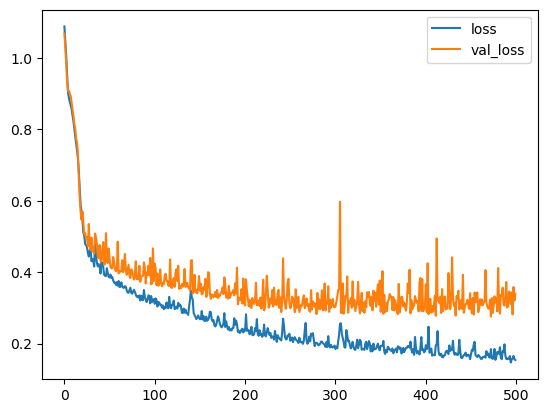

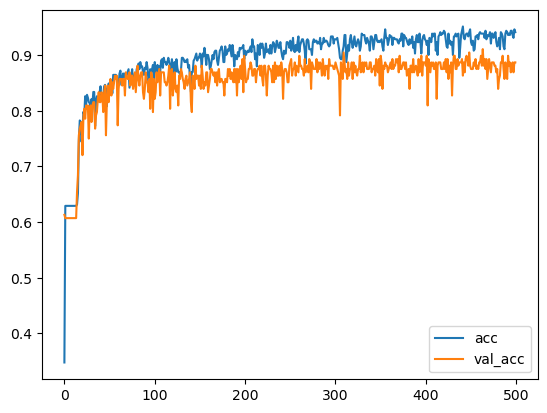

In [266]:
train_results =  pd.DataFrame(history.history)
train_results[['loss','val_loss']].plot()
train_results[['acc','val_acc']].plot()

## 이상치 제거

In [267]:
model.load_weights(checkpoint_path)

In [268]:
학습 = model.predict(치수_scaled[shuff_train])
검증 = model.predict(치수_scaled[shuff_val])

학습데이터 = np.argmax(학습, axis = 1)
검증데이터 = np.argmax(검증, axis = 1)
cnt_학습 = 0
cnt_검증 = 0
for i,j in zip(학습데이터, 체형_train[shuff_train]):
    if(i==j):
        cnt_학습 = cnt_학습 +1
print(f'학습 데이터:{cnt_학습} of {치수_scaled[shuff_train].shape[0]} are correct [{cnt_학습/치수_scaled[shuff_train].shape[0]*100}%]')

for i,j in zip(검증데이터, 체형_train[shuff_val]):
    if(i==j):
        cnt_검증 = cnt_검증 +1
print(f'검증 데이터:{cnt_검증} of {치수_scaled[shuff_val].shape[0]} are correct [{cnt_검증/치수_scaled[shuff_val].shape[0]*100}%]')

6/6 [==============================] - 0s 997us/step
학습 데이터:367 of 391 are correct [93.86189258312021%]
검증 데이터:146 of 168 are correct [86.90476190476191%]


In [269]:
Y_pred = model.predict(치수_scaled)
Y_pred_max = np.max(Y_pred,axis =1)

체형_pred = np.argmax(Y_pred, axis=1)
치수_train_selected = []
체형_pred_selected =[]
cnt = 0
for i,j,k,m in zip(체형_pred,체형_train,range(치수_scaled.shape[0]),Y_pred_max):
    if(i==j):
        cnt=cnt+1
        치수_train_selected.append(치수_train[k])
        체형_pred_selected.append(i)
    else:
        '''
        치수_train_selected.append(치수_train[k])
        체형_pred_selected.append(i)
        '''
        if(m < 0.7):
            치수_train_selected.append(치수_train[k])
            체형_pred_selected.append(i)
        
print(f'{cnt} of {체형_train.shape[0]} are correct [{cnt/체형_train.shape[0]*100}%]')


18/18 [==============================] - 0s 1ms/step
513 of 559 are correct [91.77101967799642%]


In [270]:
print(f'{cnt}개의 정답과 {len(치수_train_selected)-cnt}개의 모호한 데이터추출')
print(len(치수_train_selected))

513개의 정답과 19개의 모호한 데이터추출
532


## 레이블 지정

In [271]:
체형_Unlabeled_pred = model.predict(minmax_scaler.transform(치수_test))
체형_Unlabeled_pred = np.argmax(체형_Unlabeled_pred, axis=1)

8/8 [==============================] - 0s 855us/step


In [272]:
#체형_test = 체형_Unlabeled_pred

## 데이터 병합

In [273]:
치수_merge = np.concatenate((치수_train_selected, 치수_test), axis = 0)
체형_merge = np.concatenate((체형_pred_selected, 체형_test))
체형_merge = np.reshape(체형_merge, (치수_merge.shape[0],1))
data_merge = np.concatenate((치수_merge,체형_merge), axis = 1)
np.random.shuffle(data_merge)

In [274]:
split = round(치수_merge.shape[0]*0.7)

In [275]:
치수2_train, 체형2_train, 치수2_test, 체형2_test = data_merge[:split,0:-1], data_merge[:split,-1], data_merge[split:,0:-1], data_merge[split:,-1]
체형2_train = 체형2_train.astype('float32')
체형2_test = 체형2_test.astype('float32')
치수2_train_scaled = minmax_scaler.transform(치수2_train)

In [276]:
치수2_train.shape


(540, 38)

In [277]:
치수2_test.shape

(231, 38)

In [278]:
th = round(치수2_train_scaled.shape[0]*0.7)

## 평가 모델 생성

In [279]:
checkpoint_path2 = './temp2/checkpoint.ckpt'
optimizer = optimizers.Adam()
model2 = Sequential()
model_check_point2 = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path2, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)
model2.add(tf.keras.layers.Dense(38, input_dim =38,activation = 'relu'))
model2.add(tf.keras.layers.Dense(19,activation = 'relu'))
model2.add(tf.keras.layers.Dense(19,activation = 'relu'))
model2.add(tf.keras.layers.Dense(9,activation = 'relu'))
model2.add(tf.keras.layers.Dense(3,  activation='softmax'))
model2.compile(
    loss=sparse_categorical_crossentropy, 
    optimizer=optimizer, 
    metrics=['acc'])
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 38)                1482      
                                                                 
 dense_86 (Dense)            (None, 19)                741       
                                                                 
 dense_87 (Dense)            (None, 19)                380       
                                                                 
 dense_88 (Dense)            (None, 9)                 180       
                                                                 
 dense_89 (Dense)            (None, 3)                 30        
                                                                 
Total params: 2,813
Trainable params: 2,813
Non-trainable params: 0
_________________________________________________________________


In [280]:
model2.load_weights(checkpoint_path)

In [281]:
history2 = model2.fit(치수2_train_scaled[:th], 체형2_train[:th], validation_data=(치수2_train_scaled[th:], 체형2_train[th:]), epochs = 500, callbacks = [model_check_point])

Epoch 1/500
12/12 [==============================] - 1s 20ms/step - loss: 0.2830 - acc: 0.8968 - val_loss: 0.2876 - val_acc: 0.9012
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 0.2625 - acc: 0.9101 - val_loss: 0.2700 - val_acc: 0.8827
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 0.2406 - acc: 0.9233 - val_loss: 0.2883 - val_acc: 0.8889
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 0.2460 - acc: 0.9101 - val_loss: 0.2635 - val_acc: 0.9074
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 0.2257 - acc: 0.9233 - val_loss: 0.2546 - val_acc: 0.9136
Epoch 6/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2257 - acc: 0.9153 - val_loss: 0.2566 - val_acc: 0.8704
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 0.2205 - acc: 0.9286 - val_loss: 0.2440 - val_acc: 0.8951
Epoch 8/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2309 - 

12/12 [==============================] - 0s 3ms/step - loss: 0.1396 - acc: 0.9418 - val_loss: 0.1979 - val_acc: 0.9012
Epoch 64/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1439 - acc: 0.9418 - val_loss: 0.1909 - val_acc: 0.9259
Epoch 65/500
12/12 [==============================] - 0s 6ms/step - loss: 0.1335 - acc: 0.9497 - val_loss: 0.1849 - val_acc: 0.9074
Epoch 66/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1422 - acc: 0.9286 - val_loss: 0.2796 - val_acc: 0.8951
Epoch 67/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1452 - acc: 0.9418 - val_loss: 0.1951 - val_acc: 0.8951
Epoch 68/500
12/12 [==============================] - 0s 6ms/step - loss: 0.1341 - acc: 0.9471 - val_loss: 0.1844 - val_acc: 0.9136
Epoch 69/500
12/12 [==============================] - 0s 4ms/step - loss: 0.1264 - acc: 0.9392 - val_loss: 0.2027 - val_acc: 0.8951
Epoch 70/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1349 - acc: 0

Epoch 125/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0993 - acc: 0.9550 - val_loss: 0.2360 - val_acc: 0.9012
Epoch 126/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0906 - acc: 0.9603 - val_loss: 0.2071 - val_acc: 0.9012
Epoch 127/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0835 - acc: 0.9735 - val_loss: 0.1856 - val_acc: 0.9383
Epoch 128/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0888 - acc: 0.9603 - val_loss: 0.1942 - val_acc: 0.9074
Epoch 129/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0787 - acc: 0.9709 - val_loss: 0.1902 - val_acc: 0.9136
Epoch 130/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0843 - acc: 0.9683 - val_loss: 0.1959 - val_acc: 0.9321
Epoch 131/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0879 - acc: 0.9630 - val_loss: 0.1928 - val_acc: 0.9074
Epoch 132/500
12/12 [==============================] - 0s 7ms/step - 

12/12 [==============================] - 0s 4ms/step - loss: 0.0515 - acc: 0.9841 - val_loss: 0.1938 - val_acc: 0.9259
Epoch 187/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0522 - acc: 0.9841 - val_loss: 0.1834 - val_acc: 0.9321
Epoch 188/500
12/12 [==============================] - 0s 7ms/step - loss: 0.0625 - acc: 0.9788 - val_loss: 0.1737 - val_acc: 0.9321
Epoch 189/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0522 - acc: 0.9841 - val_loss: 0.1846 - val_acc: 0.9259
Epoch 190/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0496 - acc: 0.9841 - val_loss: 0.1990 - val_acc: 0.9321
Epoch 191/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0513 - acc: 0.9788 - val_loss: 0.2151 - val_acc: 0.9321
Epoch 192/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0511 - acc: 0.9868 - val_loss: 0.2427 - val_acc: 0.9259
Epoch 193/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0520 -

Epoch 248/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0545 - acc: 0.9762 - val_loss: 0.2429 - val_acc: 0.9198
Epoch 249/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0362 - acc: 0.9894 - val_loss: 0.2283 - val_acc: 0.9321
Epoch 250/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0342 - acc: 0.9868 - val_loss: 0.1887 - val_acc: 0.9568
Epoch 251/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0530 - acc: 0.9841 - val_loss: 0.1764 - val_acc: 0.9321
Epoch 252/500
12/12 [==============================] - 0s 4ms/step - loss: 0.1519 - acc: 0.9339 - val_loss: 0.2896 - val_acc: 0.9136
Epoch 253/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0842 - acc: 0.9603 - val_loss: 0.2396 - val_acc: 0.9136
Epoch 254/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0572 - acc: 0.9735 - val_loss: 0.2100 - val_acc: 0.9383
Epoch 255/500
12/12 [==============================] - 0s 4ms/step - 

12/12 [==============================] - 0s 4ms/step - loss: 0.0233 - acc: 0.9947 - val_loss: 0.2096 - val_acc: 0.9259
Epoch 310/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0229 - acc: 0.9974 - val_loss: 0.2673 - val_acc: 0.9321
Epoch 311/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0238 - acc: 0.9947 - val_loss: 0.2722 - val_acc: 0.9321
Epoch 312/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0284 - acc: 0.9894 - val_loss: 0.2074 - val_acc: 0.9383
Epoch 313/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0435 - acc: 0.9788 - val_loss: 0.2647 - val_acc: 0.9259
Epoch 314/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0385 - acc: 0.9894 - val_loss: 0.2110 - val_acc: 0.9198
Epoch 315/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0483 - acc: 0.9894 - val_loss: 0.3059 - val_acc: 0.9259
Epoch 316/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0478 -

Epoch 371/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0251 - acc: 0.9947 - val_loss: 0.1962 - val_acc: 0.9506
Epoch 372/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0401 - acc: 0.9868 - val_loss: 0.2237 - val_acc: 0.9444
Epoch 373/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0205 - acc: 0.9921 - val_loss: 0.2871 - val_acc: 0.9259
Epoch 374/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0318 - acc: 0.9921 - val_loss: 0.3346 - val_acc: 0.9259
Epoch 375/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0359 - acc: 0.9868 - val_loss: 0.2342 - val_acc: 0.9444
Epoch 376/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0360 - acc: 0.9894 - val_loss: 0.2912 - val_acc: 0.9321
Epoch 377/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0237 - acc: 0.9894 - val_loss: 0.2403 - val_acc: 0.9444
Epoch 378/500
12/12 [==============================] - 0s 4ms/step - 

12/12 [==============================] - 0s 4ms/step - loss: 0.0200 - acc: 0.9947 - val_loss: 0.2710 - val_acc: 0.9383
Epoch 433/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0155 - acc: 0.9947 - val_loss: 0.2809 - val_acc: 0.9444
Epoch 434/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0216 - acc: 0.9894 - val_loss: 0.3165 - val_acc: 0.9321
Epoch 435/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0178 - acc: 0.9921 - val_loss: 0.2312 - val_acc: 0.9383
Epoch 436/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0309 - acc: 0.9868 - val_loss: 0.2326 - val_acc: 0.9444
Epoch 437/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0358 - acc: 0.9868 - val_loss: 0.2708 - val_acc: 0.9321
Epoch 438/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0307 - acc: 0.9894 - val_loss: 0.3885 - val_acc: 0.9074
Epoch 439/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0480 -

Epoch 494/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0374 - acc: 0.9894 - val_loss: 0.3623 - val_acc: 0.9321
Epoch 495/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0266 - acc: 0.9947 - val_loss: 0.2918 - val_acc: 0.9259
Epoch 496/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0187 - acc: 0.9947 - val_loss: 0.2826 - val_acc: 0.9383
Epoch 497/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0195 - acc: 0.9947 - val_loss: 0.2791 - val_acc: 0.9383
Epoch 498/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0346 - acc: 0.9868 - val_loss: 0.2578 - val_acc: 0.9383
Epoch 499/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0341 - acc: 0.9868 - val_loss: 0.2222 - val_acc: 0.9568
Epoch 500/500
12/12 [==============================] - 0s 3ms/step - loss: 0.0371 - acc: 0.9868 - val_loss: 0.2236 - val_acc: 0.9444


<AxesSubplot:>

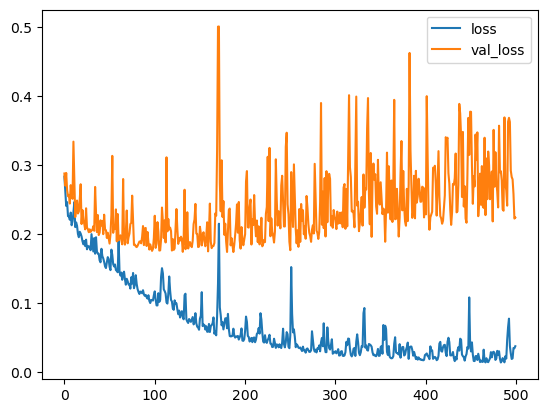

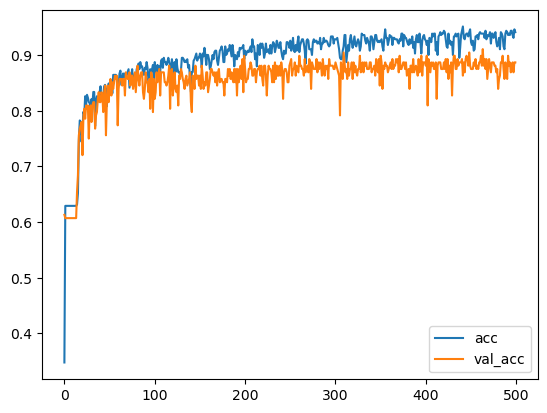

In [282]:
results = pd.DataFrame(history2.history)
results[['loss', 'val_loss']].plot()
train_results[['acc','val_acc']].plot()

In [283]:
model2.load_weights(checkpoint_path)

In [284]:
학습2 = model2.predict(치수2_train_scaled[:th])
검증2 = model2.predict(치수2_train_scaled[th:])

학습데이터2 = np.argmax(학습2, axis = 1)
검증데이터2 = np.argmax(검증2, axis = 1)
cnt_학습2 = 0
cnt_검증2 = 0
for i,j in zip(학습데이터2, 체형2_train[:th]):
    if(i==j):
        cnt_학습2 = cnt_학습2 +1
print(f'학습 데이터:{cnt_학습2} of {치수2_train_scaled[:th].shape[0]} are correct [{cnt_학습2/치수2_train_scaled[:th].shape[0]*100}%]')

for i,j in zip(검증데이터2, 체형2_train[th:]):
    if(i==j):
        cnt_검증2 = cnt_검증2 +1
print(f'검증 데이터:{cnt_검증2} of {치수2_train_scaled[th:].shape[0]} are correct [{cnt_검증2/치수2_train_scaled[th:].shape[0]*100}%]')

6/6 [==============================] - 0s 997us/step
학습 데이터:368 of 378 are correct [97.35449735449735%]
검증 데이터:151 of 162 are correct [93.20987654320987%]


In [285]:
all_predict = model2.predict(치수2_train_scaled)

17/17 [==============================] - 0s 873us/step


In [286]:
체형2_train.shape

(540,)

In [287]:
All_predict = np.argmax(all_predict, axis = 1)

In [288]:
All_predict.shape

(540,)

In [289]:
test_pred = model2.predict(minmax_scaler.transform(치수2_test))
Test_pred = np.argmax(test_pred,axis =1)

Test_pred.shape

8/8 [==============================] - 0s 855us/step


(231,)

In [290]:
cnt =0
for i in range(Test_pred.shape[0]):
    if(Test_pred[i]==체형2_test[i]):
        cnt=cnt+1
        
print(f'error is {cnt/Test_pred.shape[0]*100}')

error is 94.37229437229438


In [291]:
치수2_train, 체형2_train, 치수2_test, 체형2_test

(array([[1030.01, 423.41, 357.06, 643.02, 177124.77, 1712.25, 354.52,
         360.85, 655.48, 658.52, 179178.73, 195304.94, 1687.81, 1710.48,
         375.76, 672.82, 211450.57, 1757.3, 383.36, 379.15, 639.45,
         658.96, 198271.95, 207918.43, 1707.03, 1744.16, 432.12, 400.08,
         564.86, 178236.44, 1563.89, 299.45500000000004,
         484.08500000000004, 152211.715, 1285.355, 118.41998125031606,
         508.2957873470137, 314.43179400311925],
        [940.01, 335.36, 255.91, 511.02, 113972.64, 1325.98, 271.31,
         304.56, 528.35, 581.29, 117621.94, 142997.74, 1360.11, 1486.47,
         318.37, 584.75, 152727.28, 1502.37, 308.73, 314.86, 552.11,
         559.87, 140834.39, 147354.47, 1430.69, 1459.49, 328.66, 301.23,
         471.18, 116543.39, 1253.2, 230.19, 411.74, 106919.4325,
         1081.0825, 98.90034525579685, 464.4833941526565,
         259.67705955214456],
        [890.01, 364.85, 284.35, 465.15, 101850.19, 1330.62, 291.71,
         317.15, 487.14, 536.33, 

In [292]:
TotalX = np.concatenate((치수2_train,치수2_test), axis = 0)
Totaly = np.concatenate((체형2_train,체형2_test), axis = 0)

In [293]:
Total_pred = model2.predict(minmax_scaler.transform(TotalX))
Total_pred = np.argmax(Total_pred,axis = 1)

25/25 [==============================] - 0s 811us/step


In [294]:
cnt =0
for i in range(Total_pred.shape[0]):
    if(Total_pred[i]==Totaly[i]):
        cnt=cnt+1
        
print(f'error is {cnt/Total_pred.shape[0]*100}')

error is 95.59014267185474


In [254]:
Total_pred.shape[0]

771

In [173]:
asdasd = minmax_scaler.transform(치수)
asdasd

array([[5.19230769e-01, 6.84922554e-01, 5.36011730e-01, 6.50491868e-01,
        7.15909874e-01, 6.59755602e-01, 5.83221434e-01, 6.23369528e-01,
        7.25866900e-01, 6.83393895e-01, 6.63121295e-01, 7.99428638e-01,
        6.16417320e-01, 6.71278937e-01, 6.38854700e-01, 7.56829343e-01,
        8.51763580e-01, 7.89158849e-01, 6.90896477e-01, 6.12609167e-01,
        9.51890034e-01, 8.56873397e-01, 8.94541583e-01, 8.83093752e-01,
        8.13233167e-01, 8.60918968e-01, 6.50844464e-01, 8.38114669e-01,
        7.47852644e-01, 7.25014644e-01, 7.43434287e-01, 6.62301861e-01,
        7.70871143e-01, 8.89636419e-01, 7.86281662e-01, 6.67902231e-01,
        8.77681478e-01, 6.81070291e-01],
       [4.42307692e-01, 7.02437749e-01, 6.58064516e-01, 6.59998013e-01,
        7.64890494e-01, 6.84770835e-01, 6.19349063e-01, 6.47408318e-01,
        7.41403777e-01, 6.86373547e-01, 7.29612481e-01, 8.03585214e-01,
        6.40924563e-01, 6.86524074e-01, 6.50709335e-01, 7.70564764e-01,
        8.57035189e-01,